Brianna Patten  
9/15/2025

# CS Network Science — Project 1: *From Bipartite to Insights*  
**Starter Notebook (Created 2025-08-29)**  
Use this scaffold to complete your analysis. Read each markdown cell carefully, then write code in the following cell.

**Rules**
- You may (and should) use a coding assistant (ChatGPT, Gemini, etc.).
- Cite your prompts and summarize what you accepted/changed in the **LLM Usage Log** section.
- Set random seeds for reproducibility.
- Keep your code readable and modular.

**Grading**: Points are shown next to each task. Total = **100 points**.


## Dataset Selection (no points)
Pick **one** dataset slice so each submission is unique. A few ideas:
- **MovieLens** (users–movies): ratings subset such as small (100k).
- **Citi Bike NYC** (trips–stations): one month of trips.
- **Stack Overflow** (posts–tags): a CSV of post–tag pairs.
- **OpenFlights** (airline–airport or airport–route).

You may choose another public bipartite source with instructor approval. Keep it small for this first project.


### Task 1 — Imports & Environment *(5 points)*
Write code to:
1) Import standard libraries (`pandas`, `numpy`, `matplotlib`, `networkx`, and any community package you choose).
2) Set a global random seed.
3) Configure matplotlib for inline plots with a reasonable default figure size.


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Optional community detection package (e.g., python-louvain)
# from community import community_louvain

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Plot defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True


### Task 2 — Load a Raw Slice of Your Dataset *(10 points)*
Write code to:
- Load your raw data from a local file or URL.
- Display the **shape** and a **5-row preview**.
- Briefly print what's in each column (types or a short description).


In [2]:
#dataset printing and formatting
df = pd.read_csv('u.data', sep='\t', names=["userId", "movieId", "rating", "timestamp"])
print(df.shape)
display(df.head())
print(df.dtypes)


(100000, 4)


,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


userId       int64
movieId      int64
rating       int64
timestamp    int64
dtype: object


### Task 3 — Minimal Cleaning *(5 points)*
Write code to perform **lightweight cleaning** as appropriate for your dataset, such as:
- Dropping rows with missing critical IDs
- Filtering out extremely rare items/tags or implausible records
- Keeping a focused time window or category subset
- Print the new shape and a short note of what you did.


In [3]:
og_df = df.copy()
#dropping rows with missing critical IDs
df = df.dropna(subset=['userId', 'movieId'])
#filtering for rare movies
movie_counts = df['movieId'].value_counts()
common_movies = movie_counts[movie_counts >= 10].index
df = df[df['movieId'].isin(common_movies)]
#filtering for rare users
user_counts = df['userId'].value_counts()
common_users = user_counts[user_counts >= 10].index
df = df[df['userId'].isin(common_users)]

print('Shape before cleaning:', og_df.shape)
print('Shape after cleaning:', df.shape)
print('Notes: Deleted rare movies and users with less than 10 occurences each.')


Shape before cleaning: (100000, 4)
Shape after cleaning: (97953, 4)
Notes: Deleted rare movies and users with less than 10 occurences each.


### Task 4 — Build a Bipartite Graph *(10 points)*
Define which side is **Top** (e.g., users) and which is **Bottom** (e.g., items). Then:
- Construct a bipartite graph `B` using `networkx`.
- Ensure each node has an attribute `bipartite` = 0 (Top) or 1 (Bottom).
- Print node/edge counts for sanity.


In [4]:
#constructing graph
top_col = 'userId'
bottom_col = 'movieId'
B = nx.Graph()
#ensuring nodes have attribute 0 or 1
B.add_nodes_from(df[top_col].unique(), bipartite=0)
B.add_nodes_from(df[bottom_col].unique(), bipartite=1)
edges = list(zip(df[top_col], df[bottom_col]))
B.add_edges_from(edges)
#printing node/edge counts
print('Bipartite nodes:', B.number_of_nodes(), 'edges:', B.number_of_edges())


Bipartite nodes: 1221 edges: 92941


In [5]:
#Adding node attributes to use later
users = pd.read_csv('u.user', sep='|', names=['userId','age','gender','occupation','zip'])
for row in users.itertuples(index=False):
    if B.has_node(row.userId):
        B.nodes[row.userId]['age'] = row.age
        B.nodes[row.userId]['gender'] = row.gender
        B.nodes[row.userId]['occupation'] = row.occupation

#importing metadata and adding genre attributes
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', header=None)
genre_cols = ['unknown','Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary',
              'Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
              'Thriller','War','Western']

for row in movies.itertuples(index=False):
    movie_id = row[0]
    if B.has_node(movie_id):
        B.nodes[movie_id]['title'] = row[1]
        B.nodes[movie_id]['release_date'] = row[2]
        for i, g in enumerate(genre_cols):
            B.nodes[movie_id][g] = row[5+i] 


### Task 5 — One-Mode Projection *(10 points)*
Create **one** projection (e.g., Bottom–Bottom / item–item), where edge weights represent shared neighbors.
- Build the projected graph `G`.
- Keep only the **largest connected component** of `G`.
- Print node/edge counts.


In [6]:
#building projected graph
from networkx.algorithms import bipartite
bottom_nodes = [n for n,d in B.nodes(data=True) if d.get('bipartite')==1]
G = bipartite.weighted_projected_graph(B, bottom_nodes)
#keeping largest connected component of G
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
#printing node/edge counts
print('Projected G:', G.number_of_nodes(), 'nodes /', G.number_of_edges(), 'edges')


Projected G: 1221 nodes / 723369 edges


### Task 6 — Degree & Weighted Degree Summary *(8 points)*
Compute and display:
- Top 10 nodes by degree
- Top 10 nodes by **weighted** degree (sum of incident weights)
Show a simple bar plot of the **degree distribution** (or weighted degree distribution).


Top 10
Node 22: Degree 1220
Node 298: Degree 1220
Node 305: Degree 1220
Node 6: Degree 1220
Node 62: Degree 1220
Node 286: Degree 1220
Node 200: Degree 1220
Node 210: Degree 1220
Node 194: Degree 1220
Node 291: Degree 1220

Weighted Top 10
Node 13: Weighted Degree 137759
Node 655: Weighted Degree 137660
Node 181: Weighted Degree 135795
Node 7: Weighted Degree 135427
Node 405: Weighted Degree 134600
Node 234: Weighted Degree 132448
Node 1: Weighted Degree 130578
Node 276: Weighted Degree 130337
Node 50: Weighted Degree 129659
Node 222: Weighted Degree 129635


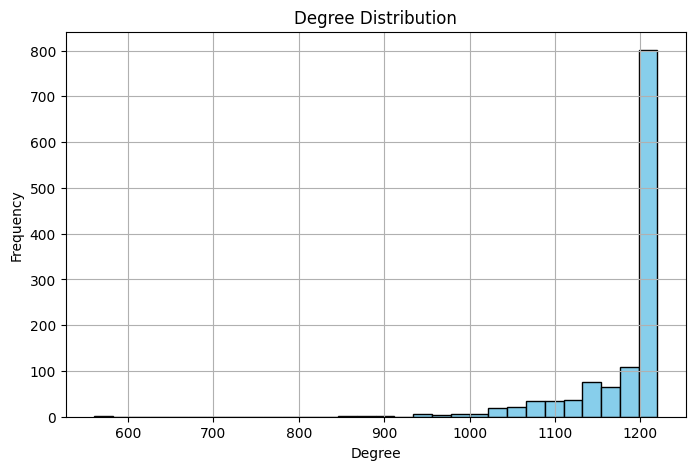

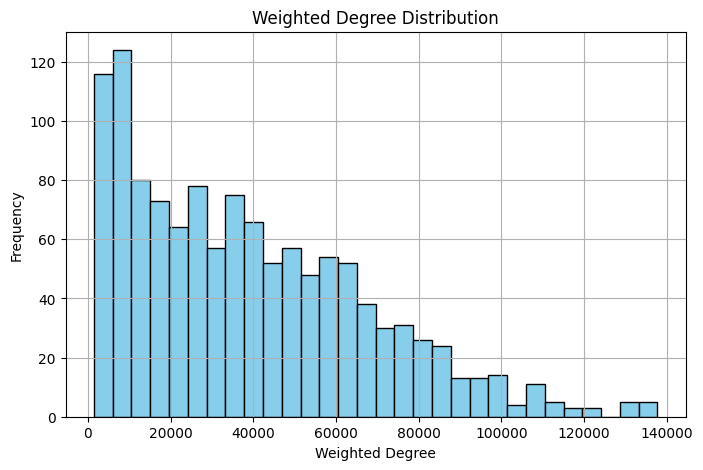

In [7]:
#computing top 10 nodes by degree
degrees = dict(G.degree())
#computing top 10 nodes by weighted degree
w_degrees = dict(G.degree(weight='weight'))
top_10 = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
weighted_top_10 = sorted(w_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

#outputting top 10 nodes by degree
print("Top 10")
for node, degree in top_10:
    print(f"Node {node}: Degree {degree}")

#outputting top 10 nodes by weighted degree
print("\nWeighted Top 10")
for node, degree in weighted_top_10:
    print(f"Node {node}: Weighted Degree {degree}")

#showing histogram/bar plot of degree distribution
plt.hist(degrees.values(), bins=30, color='skyblue', edgecolor='black')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

#showing histogram/bar plot of degree distribution
plt.hist(w_degrees.values(), bins=30, color='skyblue', edgecolor='black')
plt.title('Weighted Degree Distribution')
plt.xlabel('Weighted Degree')
plt.ylabel('Frequency')
plt.show()


### Task 7 — Giant Component Size, Average Path Length, Diameter *(10 points)*
Compute on the **largest connected component** of `G`:
- Size (nodes, edges)
- Average shortest path length (if graph is not too large; otherwise sample)
- Diameter (exact or approximate)
Print the results with brief comments.


In [8]:
#checking if connected
print("Connected?: ", nx.is_connected(G))
H = G 
#computing average shortest path length
n_nodes, n_edges = H.number_of_nodes(), H.number_of_edges()
try:
    aspl = nx.average_shortest_path_length(H)
except Exception:
     aspl = None
#computing diameter
try:
    diameter = nx.diameter(H) 
except Exception:
    diameter = None

print('Notes: Printing umber of nodes, edges, average path length, and graph diameter')
print({'nodes': n_nodes, 'edges': n_edges, 'avg_path_length': aspl, 'diameter': diameter})
print('Notes: Most movies are connected to each other, and the small diameter indicates that any two movies can be reached in at most two steps, which continues to indicate strong connectivity.')



Connected?:  True
Notes: Printing umber of nodes, edges, average path length, and graph diameter
{'nodes': 1221, 'edges': 723369, 'avg_path_length': 1.028787207475732, 'diameter': 2}
Notes: Most movies are connected to each other, and the small diameter indicates that any two movies can be reached in at most two steps, which continues to indicate strong connectivity.


### Task 8 — Clustering Coefficients *(6 points)*
Compute the **global clustering coefficient** and show the **distribution of local clustering** values (histogram or box plot).


Global clustering coefficient: 0.9753038495614297


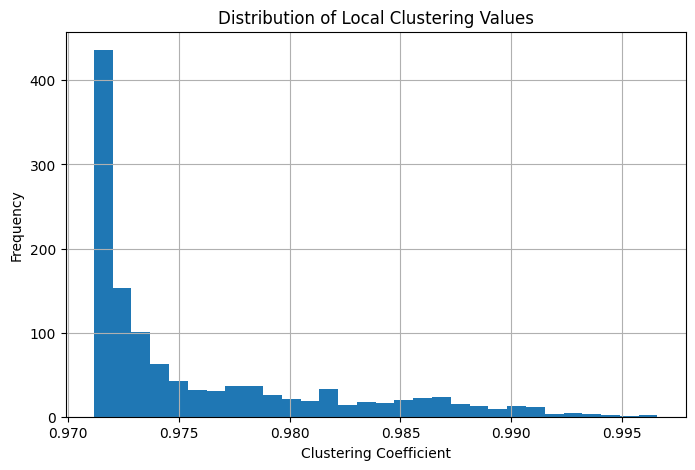

In [9]:
#computing global clustering coefficient
global_c = nx.transitivity(G)
local_c = nx.clustering(G, weight=None)
print('Global clustering coefficient:', global_c)
# plotting distribution of local clustering values as a histogram
plt.hist(local_c.values(), bins=30)
plt.title('Distribution of Local Clustering Values')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()


### Task 9 — Assortativity *(6 points)*
Compute **degree assortativity** for `G`.
If you have a categorical attribute (e.g., genre, borough, airline), compute assortativity by that attribute and comment briefly.


In [10]:
#computing degree assortativity for G
deg_assort = nx.degree_assortativity_coefficient(G)
print('Degree assortativity:', deg_assort)
print("\n")
#computing assortativity by 'genre' attribute
for g in genre_cols:
    attr_assort = nx.attribute_assortativity_coefficient(G, g)
    print("Attribute: ", g)
    print('Attribute assortativity:', attr_assort)
print("Notes: Degree assortativity is slightly negative, meaning high-degree movies are often connected with low degree movies.")
print("All of the negative genre assorativity values show that there is little assorative mixing by genre (movies of the same genre are not necessarily clustered in terms of user).")


Degree assortativity: -0.06842509778017838


Attribute:  unknown
Attribute assortativity: -0.05486741407872414
Attribute:  Action
Attribute assortativity: -0.011937023330395162
Attribute:  Adventure
Attribute assortativity: -0.017784550723598087
Attribute:  Animation
Attribute assortativity: -0.03363102519030903
Attribute:  Children's
Attribute assortativity: -0.020108203915314614
Attribute:  Comedy
Attribute assortativity: -0.007898317434987737
Attribute:  Crime
Attribute assortativity: -0.024412173541684633
Attribute:  Documentary
Attribute assortativity: -0.041599659142321395
Attribute:  Drama
Attribute assortativity: -0.006450875120890219
Attribute:  Fantasy
Attribute assortativity: -0.04233083395577733
Attribute:  Film-Noir
Attribute assortativity: -0.041870204979380356
Attribute:  Horror
Attribute assortativity: -0.024300311454515697
Attribute:  Musical
Attribute assortativity: -0.0295600621525076
Attribute:  Mystery
Attribute assortativity: -0.029164329062471486
Attribute:  Roma

### Task 10 — Community Detection & Interpretation *(10 points)*
Run a community detection algorithm (e.g., Louvain). Then:
- Report the number of communities and sizes of the top 3.
- Compute modularity if available.
- Write **one sentence per top community** interpreting what it represents (based on metadata you have).

In [11]:
#reporting number of communities and sizes of top 3
import community as community_louvain
partition = community_louvain.best_partition(G, random_state=SEED, weight='weight')
# # Count sizes
from collections import Counter
sizes = Counter(partition.values())
print('Communities:', len(sizes))
print('Top 3 sizes:', sizes.most_common(3))
#computing modularity
modularity = community_louvain.modularity(partition, G, weight='weight')
print('Modularity:', modularity)

#Community 0 - 485 nodes
#Community 3 - 371 nodes
#Community 2 - 190 nodes

#printing top genres in top communities to help write notes
for community_id, size in sizes.most_common(3):
    community_movies = [movie_id for movie_id, comm_id in partition.items() if comm_id == community_id]
    genres = Counter()
    for movie_id in community_movies:
        if movie_id in G.nodes:
            for g in genre_cols:
                if G.nodes[movie_id].get(g) == 1:
                    genres[g] += 1
    popular_genres = genres.most_common(3)
    print(f"\nCommunity {community_id} (size {size}):")
    for genre in popular_genres:
        print(f"Genre: {genre}")

print("Community 0 is dominated by Drama, Comedy, and Action genres, while are all mainstream film types.")
print("Communities 2 and 3 are dominated by Drama, Comedy, and Thriller genres, ")
print("which is similar to Community 0, but Community 3 ranks Drama above Comedy, which is the opposite of Community 2.")

Communities: 4
Top 3 sizes: [(0, 485), (3, 371), (2, 190)]
Modularity: 0.05143922407002251

Community 0 (size 485):
Genre: ('Drama', 206)
Genre: ('Comedy', 156)
Genre: ('Action', 92)

Community 3 (size 371):
Genre: ('Drama', 131)
Genre: ('Comedy', 99)
Genre: ('Thriller', 60)

Community 2 (size 190):
Genre: ('Comedy', 49)
Genre: ('Drama', 43)
Genre: ('Thriller', 30)
Community 0 is dominated by Drama, Comedy, and Action genres, while are all mainstream film types.
Communities 2 and 3 are dominated by Drama, Comedy, and Thriller genres, 
which is similar to Community 0, but Community 3 ranks Drama above Comedy, which is the opposite of Community 2.


### Task 11 — Five Random Shortest Paths *(6 points)*
Randomly sample **five** node pairs from the largest component and report:
- The path length, and the node sequence for each pair.
If disconnected (shouldn’t be on GC), resample.


In [12]:
#randomly sampling five node pairs from largest component
import random
nodes = list(G.nodes())
for i in range(5):
     s, t = random.sample(nodes, 2)
     try:
         p = nx.shortest_path(G, s, t, weight=None)
         #reporting path length and node sequence
         print(f'Pair {i+1}: {s} -> {t} | length={len(p)-1} | path={p}')
     except nx.NetworkXNoPath:
         #resampling if disconnected
         print('No path found; resample if needed')


Pair 1: 146 -> 72 | length=1 | path=[np.int64(146), np.int64(72)]
Pair 2: 586 -> 501 | length=1 | path=[np.int64(586), np.int64(501)]
Pair 3: 470 -> 321 | length=1 | path=[np.int64(470), np.int64(321)]
Pair 4: 283 -> 1068 | length=1 | path=[np.int64(283), 1068]
Pair 5: 114 -> 897 | length=1 | path=[np.int64(114), 897]


### Task 12 — Small Subgraph Visualization *(8 points)*
Create a visualization of a **small subgraph**:
- Select the top 50 nodes by **weighted degree** (or degree if unweighted).
- Draw with a spring layout; label the top 10 nodes.
- Include a legend or caption explaining what is shown.


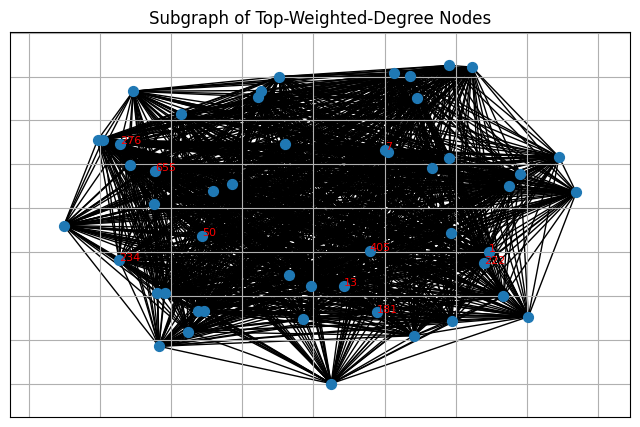

In [13]:
#computing weighted degree and selecting top nodes
wdeg = dict(G.degree(weight='weight'))
top_nodes = [n for n,_ in sorted(wdeg.items(), key=lambda x: x[1], reverse=True)[:50]]
S = G.subgraph(top_nodes).copy()
pos = nx.spring_layout(S, seed=SEED)
nx.draw_networkx(S, pos=pos, with_labels=False, node_size=50)
# Label top 10
for n,_ in list(sorted(wdeg.items(), key=lambda x: x[1], reverse=True))[:10]:
    if n in S:
        x,y = pos[n]
        plt.text(x, y, str(n), fontsize=8, color ='red')
#including caption (title) explaining what is shown
plt.title('Subgraph of Top-Weighted-Degree Nodes')
plt.show()


### Task 13 — (Optional) Weighted vs. Unweighted Comparison *(up to 5 bonus points)*
Compare one metric (clustering, assortativity, or community modularity) under weighted vs. unweighted assumptions. Briefly comment on the difference.


In [14]:
#comparing community modularity weighted and unweighetd 
partition = community_louvain.best_partition(G, random_state=SEED, weight='weight')
modularity = community_louvain.modularity(partition, G, weight='weight')

unweighted_partition = community_louvain.best_partition(G, random_state=SEED)
unweighted_modularity = community_louvain.modularity(unweighted_partition, G)

print('Weighted modularity:', modularity)
print('Unweighted modularity:', unweighted_modularity)
print("Notes: The weighted and unweight community modularities are the same.")
print("This means that most movies are connected to every other movie, so counting edge weights does not change the community structure")
print("This is somewhat expected, since popular movies are commonly watched, and since we removed the more rarely watched movies.")

Weighted modularity: 0.05143922407002251
Unweighted modularity: 0.05143922407002251
Notes: The weighted and unweight community modularities are the same.
This means that most movies are connected to every other movie, so counting edge weights does not change the community structure
This is somewhat expected, since popular movies are commonly watched, and since we removed the more rarely watched movies.


### Task 14 — (Optional) Robustness Experiment *(up to 5 bonus points)*
Simulate node removal:
- Random removal in steps; plot giant-component size vs. fraction removed.
- Targeted removal by decreasing weighted degree; plot on same figure.
Briefly compare the curves.


In [15]:
# TODO (Optional): Implement Task 14 — Robustness (up to 5 bonus pts)
# # Outline:
# # for each fraction f in np.linspace(0,1,...) remove nodes and measure GC size


### Task 15 — Mini Write-up *(10 points)*
In a short markdown cell, summarize:
- Structure (density, paths, clustering) in one paragraph.
- Communities (count, themes) in one paragraph.
- One *surprising* finding in 1–2 sentences.


**Structure**:  
Structure describes how connected a network is. It includes metrics like whether it is dense or sparse (with many edges or few), how long the paths between nodes are and the average shortest path length, and whether nodes are formed in groups. This helps observations about the distribution of connections.  
  
**Communities**:  
Communities describe the groups of nodes that are strongly connected to each other, more so than the rest of the network. This can help uncover patterns in the data. The 'theme' of each community can also be shown through node attributes/metadata.  
  
**Surprising finding:**  
Specific to the movie dataset, I did not expect most movies to be connected with a short path length. I am aware that many movies are popular for a reason, but even after cleaning the "rarer" movies, I expected a longer shortest path length and weaker connectivity.

### Task 16 — LLM Usage Log *(5 points)*
Paste your **2–3 most helpful prompts** to the LLM and briefly state what you accepted vs. modified. Two or three bullet points are fine.


ChatGPT: "Help me print and format this .data file"  
    -Original: df = pd.read_csv('u.data')  
    -Accepted: df = pd.read_csv('u.data', sep='\t')  
  
ChatGPT: "Help me attach the movie attributes to the nodes"  
    -Original: -  
    -Accepted: Lines 14-21 of Task 4, cell 2  